In [1]:
import pandas as pd
df_a = pd.read_csv(r"D:\桌面\大数据竞赛\训练集竞赛2\cwtz_train.csv")
X_numerical = df_a.iloc[:, 1:-1].values
y = df_a.iloc[:, -1].values

In [2]:
X_numerical.shape

(7236, 52)

In [3]:
import pickle
#encoded_df.pkl存储的是每个公司最近一条文本向量化的结果
with open('encoded_df.pkl', 'rb') as f:
    encoded_df = pickle.load(f)
X_text=encoded_df['Encoded Texts']

In [4]:
type(X_text)

pandas.core.series.Series

In [5]:
a = X_text.to_numpy()
b = []
for i in a:
    b.append(i)
m = pd.DataFrame(b)
X_text=m
X_text=X_text.values

In [6]:
X_text.shape

(7236, 768)

## 选取样本数量

In [7]:
import numpy as np

# 生成一组随机的行索引
n_rows = 7236
n_sample = 5000
indices = np.random.choice(n_rows, size=n_sample, replace=False)

# 从dada和bbb数组中获取相应的行
X_ts = X_text[indices]
X_ns= X_numerical[indices]
ys = y[indices]

In [8]:
ys.shape

(5000,)

In [9]:
X_ts[0].shape

(768,)

In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
scaler = StandardScaler()
X_ns = scaler.fit_transform(X_ns)

# 划分训练集和测试集
X_text_train, X_text_test, X_numerical_train, X_numerical_test, y_train, y_test = train_test_split(
    X_ts, X_ns, ys, test_size=0.2, random_state=42)

In [12]:
type(X_text_test)

numpy.ndarray

In [13]:
# 将数据转换为PyTorch张量
X_text_train = torch.tensor(X_text_train)
X_text_test = torch.tensor(X_text_test)
X_numerical_train = torch.tensor(X_numerical_train, dtype=torch.float32)
X_numerical_test = torch.tensor(X_numerical_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 将数据封装成TensorDataset
train_dataset = TensorDataset(X_text_train, X_numerical_train, y_train)
test_dataset = TensorDataset(X_text_test, X_numerical_test, y_test)

In [14]:
X_text_test[0].shape

torch.Size([768])

In [15]:
# 定义批量大小和数据加载器
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [16]:
# 定义模型
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        # self.linear0 = nn.Linear(in_features=768, out_features=500)
        self.linear1 = nn.Linear(in_features=820, out_features=500)
        self.linear2 = nn.Linear(in_features=500, out_features=100)
        self.linear3 = nn.Linear(in_features=100, out_features=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, numerical):
        # text=  text.to(torch.float)
        # text =  self.relu(self.linear0(text))
        x = torch.cat([text, numerical], dim=1)
        x=  x.to(torch.float)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.sigmoid(self.linear3(x))
        return x
# 将模型移动到GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel().to(device)
# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [17]:
num_epochs = 3
train_losses = []
test_losses = []
test_auc_scores = []
for epoch in range(num_epochs):
    # 训练模型
    train_loss = 0.0
    model.train()
    for i, batch in enumerate(train_dataloader):
        text, numerical, label = batch
        text = text.to(device)
        numerical = numerical.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(text, numerical)
        loss = criterion(output.squeeze(), label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(batch)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # 测试模型
    test_loss = 0.0
    predictions = []
    targets = []
    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            text, numerical, label = batch
            text = text.to(device)
            numerical = numerical.to(device)
            label = label.to(device)
            output = model(text, numerical)
            loss = criterion(output.squeeze(), label)
            test_loss += loss.item() * len(batch)
            predictions.append(output.cpu().numpy())
            targets.append(label.cpu().numpy())
    test_loss /= len(test_dataset)
    test_losses.append(test_loss)
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    test_auc_score = roc_auc_score(targets, predictions)
    test_auc_scores.append(test_auc_score)

    print(f"Epoch {epoch + 1:02d}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test AUC: {test_auc_score:.4f}")

Epoch 01, Train Loss: 0.0214, Test Loss: 0.0200, Test AUC: 0.8872
Epoch 02, Train Loss: 0.0167, Test Loss: 0.0158, Test AUC: 0.8929
Epoch 03, Train Loss: 0.0156, Test Loss: 0.0142, Test AUC: 0.8786


In [18]:
text.shape

torch.Size([8, 768])

In [19]:
numerical.shape

torch.Size([8, 52])

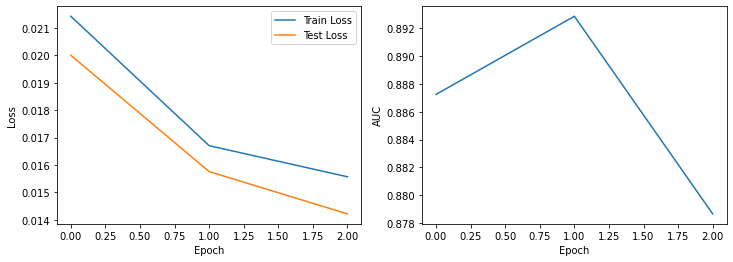

In [20]:
# 绘制 loss 和 AUC 曲线
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_losses, label="Train Loss")
ax[0].plot(test_losses, label="Test Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(test_auc_scores)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("AUC")
plt.show()

## 进行预测

In [21]:
with open('jianhuatest.pkl', 'rb') as f:
    jian = pickle.load(f)
X_test=jian["Encoded Texts"]
a = X_test
b = []
for i in a:
    b.append(i)
m = pd.DataFrame(b)
X_text=m
X_text=np.array(X_text.values)

In [23]:
df_test= pd.read_csv(r"D:\桌面\大数据竞赛\cwtz_test.csv")
# 将文本特征和数字特征分离
X_numerical_test = df_test.iloc[:, 1:].values

In [24]:
print(type(X_numerical_test),X_numerical_test.shape)
print(type(X_text),X_text.shape)

<class 'numpy.ndarray'> (804, 52)
<class 'numpy.ndarray'> (804, 768)


In [25]:
# 对数字特征进行标准化处理
scaler = StandardScaler()
X_numerical_test = scaler.fit_transform(X_numerical_test)

In [26]:
# # 将预处理后的数据转换为PyTorch张量
X_text_test = torch.tensor(X_text)
X_numerical_test = torch.tensor(X_numerical_test, dtype=torch.float32)

# # 将数据封装成TensorDataset
test_dataset = TensorDataset(X_text_test, X_numerical_test)

# 定义批量大小和数据加载器
batch_size = 32
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# 使用训练好的模型进行预测
predictions = []
model.eval()  # 切换为评估模式
with torch.no_grad():  # 禁用梯度计算，加速推理过程
    for batch in test_dataloader:
        text, numerical = batch
        text = text.to(device)
        numerical = numerical.to(device)
        output = model(text, numerical)
        predictions.extend(output.cpu().numpy().tolist())

In [27]:
# 输出预测结果
jieguo=[]
jieguo=[x[0] for x in predictions ]
df_test['预测结果'] = jieguo
df_test.to_excel(r"D:\桌面\竞赛二结果第二次.xlsx", index=False)

In [28]:
len(predictions)

804

In [30]:
#88%结果
# import matplotlib.pyplot as plt
# plt.plot(jieguo)

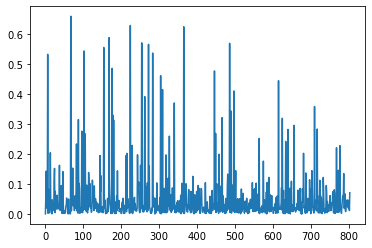

In [31]:
#92%结果
import matplotlib.pyplot as plt
plt.plot(jieguo)

In [32]:
print(sum(np.array(jieguo)>0.5))

12
